In [1]:
# import necessary libraries
import os, glob, sys
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import cv2
import multiprocessing as mp

from tqdm.auto import tqdm
from ipywidgets import FloatProgress
from scipy import ndimage
from PIL import Image
from importlib import reload
from functools import partial

# append path
sys.path.append('../')

# custom
from utils.Metrics import iou
from utils.Traits import area_calc
from utils.GetFileNames import get_file_names
import utils.SegmentImage as SegmentImage
import utils.Measure as Measure
import utils.Preprocessing as Preprocessing

/mnt/DGX01/Personal/krusepi/.venv/lib/python3.9/site-packages/albumentations/__init__.py:13: UserWarning: A new version of Albumentations is available: 1.4.18 (you have 1.4.16). Upgrade using: pip install -U albumentations. To disable automatic update checks, set the environment variable NO_ALBUMENTATIONS_UPDATE to 1.
  check_for_updates()


In [2]:
# directories
seg_path = '../data/pop_scale/pop_scale_segmentations/'
in_path = '../data/test/test_images/'
postproc_path = '../data/pop_scale/pop_scale_segmentations_postproc/'
out_path = '../data/pop_scale/pop_scale_segmentations_by_pod/'
save_path = '../data/pop_scale/pop_scale_segmentations_measurements/'

# get file names
seg_names = get_file_names(seg_path, '.png')

In [3]:
def postprocess_multi(seg_img, out_path):
    # get image
    seg = np.array(Image.open('../data/pop_scale/pop_scale_segmentations/' + seg_img)) / 255

    # remove artifacts
    post_seg = Preprocessing.remove_artifacts(seg)

    # convert to 
    post_seg = Image.fromarray((post_seg * 255).astype(np.uint8))
    post_seg.save(postproc_path + seg_img)

In [4]:
with mp.Pool(mp.cpu_count()) as pool:
        r = tqdm(pool.imap(partial(postprocess_multi, out_path=out_path), seg_names),
                total = len(seg_names))
        for _ in r:
                pass
print("Postprocessing complete.")

  0%|          | 0/767 [00:00<?, ?it/s]

Postprocessing complete.


In [5]:
# create list to store seed counts and area
measurements = []
reload(Measure)
print("Measuring pods...")
with mp.Pool(mp.cpu_count()) as pool:
        result = tqdm(pool.imap(partial(Measure.measure_pods, 
                                   pred_path=postproc_path,
                                   input_path=in_path,
                                   pod_save_path=out_path),
                                   seg_names),
                total = len(seg_names))
        for r in result:
                measurements.extend(r)
                pass
print("Measurements complete.")

Measuring pods...


  0%|          | 0/767 [00:00<?, ?it/s]

Measurements complete.


In [8]:
# save seed counts to csv
print("Number of Pods Measured:", len(measurements))
measurements = pd.DataFrame(measurements, columns=['image_name', 
                                                    'seed_count',

                                                    # areas
                                                    'seed_area',
                                                    'env_area',
                                                    'wing_area',

                                                    # perimeters
                                                    'seed_perimeter',
                                                    'env_perimeter',
                                                    'wing_perimeter',

                                                    # ...-to-total_area ratios
                                                    'seed_to_total_area',
                                                    'env_to_total_area',
                                                    'wing_to_total_area',

                                                    # ...-to-total_perimeter ratios
                                                    'seed_to_total_perimeter',
                                                    'env_to_total_perimeter',
                                                    'wing_to_total_perimeter',

                                                    # ...-to-seed ratios
                                                    'env_to_seed_area',
                                                    'wing_to_seed_area',
                                                    'env_to_seed_perimeter',
                                                    'wing_to_seed_perimeter',

                                                    # ...-to-env ratios
                                                    'wing_to_env_area',
                                                    'seed_to_env_area',
                                                    'wing_to_env_perimeter',
                                                    'seed_to_env_perimeter',

                                                    # ...-to-wing ratios
                                                    'seed_to_wing_area',
                                                    'env_to_wing_area',
                                                    'seed_to_wing_perimeter',
                                                    'env_to_wing_perimeter',
                                                            
                                                    # color
                                                    'wing_r',
                                                    'wing_g',
                                                    'wing_b',
                                                    'wing_h',
                                                    'wing_s',
                                                    'wing_v',
                                                    'wing_l',
                                                    'wing_a', 
                                                    'wing_B',

                                                    'env_r',
                                                    'env_g',
                                                    'env_b',
                                                    'env_h',
                                                    'env_s',
                                                    'env_v',
                                                    'env_l',
                                                    'env_a',
                                                    'env_B',

                                                    'seed_r',
                                                    'seed_g',
                                                    'seed_b',
                                                    'seed_h',
                                                    'seed_s',
                                                    'seed_v',
                                                    'seed_l',
                                                    'seed_a',
                                                    'seed_B'])

# remove outliers 
# seed count < 1 (outliers)
measurements = measurements[measurements["seed_count"] >= 1]

# wing area < .2 (outliers)
measurements = measurements[measurements["wing_area"] > .2]     
        
measurements.to_csv(save_path + "measurements.csv", index=False)

Number of Pods Measured: 11309


Text(0.5, 1.0, 'Image')

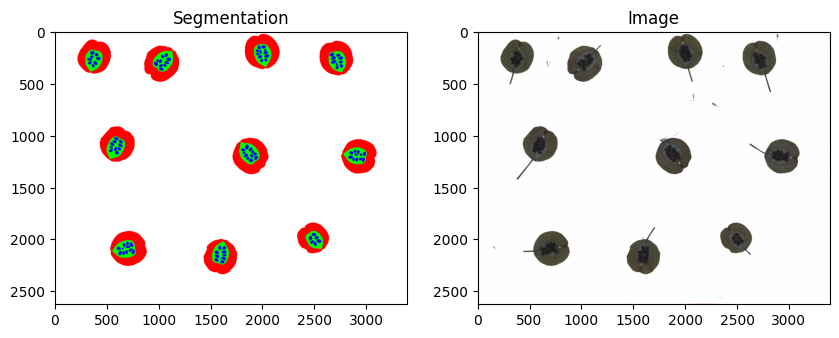

In [5]:
example_seg_name = seg_names[0]
example_img_name = example_seg_name[5:]

# load image
example_seg = np.array(Image.open(postproc_path + example_seg_name))
example_img = np.array(Image.open(in_path + example_img_name))

fig, ax = plt.subplots(1, 2, figsize=(10, 5))
ax[0].imshow(example_seg); ax[0].set_title("Segmentation")
ax[1].imshow(example_img); ax[1].set_title("Image")